## Import libraries and create some tools

In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Sequence, Any
from deepmeg.preprocessing.transforms import one_hot_encoder, zscore
from deepmeg.data.datasets import EpochsDataset
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics
from deepmeg.training.callbacks import EarlyStopping, PrintingCallback
from deepmeg.utils.viz import plot_metrics
from functools import partial


gprob = lambda x, sigma=np.sqrt(1/5): np.exp(-(x - 1)**2/sigma**2)


def gen_3d_prob(
    center: tuple[int, int, int],
    shape: tuple[int, int, int],
    gprob: Callable[[int | Sequence, int | float], float | Sequence] = gprob
) -> np.ndarray:
    """
    Generate a 3D binary array with values determined by a probability function.

    Args:
        center (tuple[int, int, int]): The center coordinates of the probability function.
        shape (tuple[int, int, int]): The shape of the output array.
        gprob (callable[[int | Sequence, int | float], float | Sequence], optional): The probability function to use. Defaults to gprob.

    Returns:
        np.ndarray: The generated 3D binary array.
    """
    w, h, l = shape
    data = np.zeros(shape)

    i, j, k = np.meshgrid(
        np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij'
    )

    pi = gprob(1 - np.abs(i - center[0])/w)
    pj = gprob(1 - np.abs(j - center[1])/h)
    pk = gprob(1 - np.abs(k - center[2])/l)
    prob = pi * pj * pk

    mask = prob > np.random.random(size=shape)
    data[mask] = 1

    return data


def gen_3d_voxel(mask: np.ndarray, ratio: int | float = 2) -> np.ndarray:
    """
    Generate a 3D voxel based on a binary mask and random noise.

    Args:
        mask (np.ndarray): A 3D binary mask.
        ratio (int | float, optional): The ratio of the maximum intensity of the voxel to the maximum intensity of the mask. 
            Defaults to 2.

    Returns:
        np.ndarray: A 3D voxel with the same shape as the mask, where the value at each voxel is the product of the 
            corresponding value in the mask, the ratio, and a random number between 0 and 1.
    """
    noise = np.random.random(mask.shape)
    return (mask*ratio + 1)*noise


def plot_2d_projections(matrix: np.ndarray) -> plt.Figure:
    """
    Plot the mean projections of a 3D matrix along the X, Y, and Z axes.

    Args:
        matrix (np.ndarray): A 3D matrix to plot.

    Returns:
        plt.Figure: A matplotlib Figure object containing the 2D projections along the X, Y, and Z axes.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(matrix.mean(axis=0))
    ax2.imshow(matrix.mean(axis=1))
    ax3.imshow(matrix.mean(axis=2))
    return fig


def gen_3d_samples(
    shape: tuple[int, int, int],
    center: tuple[int, int, int],
    n_samples: int,
    maskgen: Callable[[int | Sequence, int | float], float | Sequence] = gprob,
    datagen: Callable[[np.ndarray, int | float], np.ndarray] = gen_3d_voxel,
) -> np.ndarray:
    """
    Generate a 3D dataset of samples by sampling 3D binary masks and applying a voxel generation function.

    Args:
        shape (tuple[int, int, int]): The shape of the 3D binary masks to generate.
        center (tuple[int, int, int]): The center of the 3D binary masks to generate.
        n_samples (int): The number of 3D binary masks to generate and apply the voxel generation function.
        maskgen (Callable[[int | Sequence, int | float], float | Sequence], optional): The function used to generate the 3D binary masks.
            Defaults to gprob.
        datagen (Callable[[np.ndarray, int | float], np.ndarray], optional): The function used to generate the 3D voxel from the 3D binary masks.
            Defaults to gen_3d_voxel.

    Returns:
        np.ndarray: A 4D numpy array of shape (n_samples, *shape), where each element is a voxel generated by applying the
            voxel generation function to a binary mask generated by the mask generation function.
    """
    return np.array([
        datagen(gen_3d_prob(center, shape, maskgen))
        for _ in range(n_samples)
    ])


class ConvBlock(nn.Module):
    '''A module that implements a repetitive block of convolutional layer, batch normalization, nonlinearity, and dropout.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (Union[int, Tuple[int, int, int]]): Size of the convolutional kernel. If a single integer is given, the kernel will have the same size in all dimensions.
        stride (Union[int, Tuple[int, int, int]]): Stride of the convolution. If a single integer is given, the stride will be the same in all dimensions. Default: 1
        padding (Union[int, Tuple[int, int, int]]): Zero-padding added to all three sides of the input. If a single integer is given, the padding will be the same in all dimensions. Default: 0
        dilation (Union[int, Tuple[int, int, int]]): Spacing between kernel elements. If a single integer is given, the dilation will be the same in all dimensions. Default: 1
        drop (float): Dropout probability. Default: 0.0
        nonlinearity (nn.Module): Nonlinearity applied after batch normalization. Default: nn.ReLU()

    Attributes:
        conv (nn.Conv3d): Convolutional layer.
        bn (nn.BatchNorm3d): Batch normalization layer.
        nonlin (nn.Module): Nonlinearity applied after batch normalization.
        drop (nn.Dropout): Dropout layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor: Performs forward pass through the module.

    Returns:
        torch.Tensor: Tensor of shape (N, C, D_out, H_out, W_out) representing the output of the module.
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, drop=0.0, nonlinearity=nn.ReLU()):
        super().__init__()
        self.conv = nn.Conv3d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation
        )
        self.bn = nn.BatchNorm3d(out_channels)
        self.nonlin = nonlinearity
        self.drop = nn.Dropout(p=drop)

    def forward(self,x):
        '''Performs forward pass through the module.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, D_in, H_in, W_in).

        Returns:
            torch.Tensor: Output tensor of shape (N, C, D_out, H_out, W_out).
        '''
        x = self.conv(x)
        x = self.bn(x)
        return self.drop(self.nonlin(x))


def compute_kernel_side(
    original_side: int,
    convolved_side: int,
    stride: int = 1,
    padding: int = 0,
    dilration: int = 1
):
    """
    Compute the size of a kernel for a given convolutional layer based on its input and output size and other parameters.

    Args:
    original_side (int): The size of the input along one dimension (e.g., height or width).
    convolved_side (int): The size of the output of the convolutional layer along the same dimension.
    stride (int): The stride of the convolutional layer (default: 1).
    padding (int): The padding size of the convolutional layer (default: 0).
    dilration (int): The dilation of the convolutional layer (default: 1).

    Returns:
    int: The size of the kernel for the convolutional layer along the given dimension.
    """
    return int((original_side + 2*padding - 1 - stride*(convolved_side - 1))/dilration + 1)

def compute_out_side(
    original_side: int,
    kernel_side: int,
    stride: int = 1,
    padding: int = 0,
    dilration: int = 1
):
    """
    Computes the output size of a convolution layer given its input size, kernel size, stride, padding, and dilation.

    Args:
        original_side (int): The size of the input feature map.
        kernel_side (int): The size of the convolution kernel.
        stride (int, optional): The stride of the convolution operation. Defaults to 1.
        padding (int, optional): The padding of the convolution operation. Defaults to 0.
        dilation (int, optional): The dilation rate of the convolution operation. Defaults to 1.

    Returns:
        int: The size of the output feature map after applying the convolution operation.
    """
    return int((original_side + 2*padding - dilration*(kernel_side - 1) - 1)/stride + 1)


class VGG3D(BaseModel):
    """
    A 3D version of the VGG neural network architecture. Each convolution reduces each dimension by half.

    Parameters:
        shape (int): The size of the input tensor in the form of (z, y, x).
        n_conv_blocks (int): The number of convolutional blocks.
        max_pool_size (tuple[int, int, int]): The size of the max pooling kernel in the form of (z, y, x).
        n_fc_layers (int): The number of fully connected layers.
        n_classes (int): The number of output classes.
        convblocks_kwargs (dict): Optional arguments to pass to each ConvBlock instance.

    Raises:
        ValueError: If the size of any plane in the shape is reduced to 0 by the convolutional layers.

    Attributes:
        conv_blocks (nn.ModuleList): A list of ConvBlock instances.
        max_pool (nn.MaxPool3d): A 3D max pooling layer.
        fc_layers (nn.ModuleList): A list of fully connected layers.
        num_features (int): The total number of features in the final convolutional layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Computes the forward pass of the network.

    """
    def __init__(
        self,
        shape: int,
        n_conv_blocks: int,
        max_pool_size: tuple[int, int, int],
        n_fc_layers: int,
        n_classes: int,
        convblocks_kwargs: dict = None,
    ):
        super().__init__()

        if convblocks_kwargs is None:
            convblocks_kwargs = dict()

        self.conv_blocks = nn.ModuleList()
        self.max_pool = nn.MaxPool3d(max_pool_size, max_pool_size)
        self.fc_layers = nn.ModuleList()

        for _ in range(n_conv_blocks):

            self.conv_blocks.append(
                ConvBlock(
                    1, 1,
                    kernel_size=[compute_kernel_side(plane, plane//2) for plane in shape],
                    **convblocks_kwargs
                )
            )
            shape = [plane//2 for plane in shape]
            shape = [
                compute_out_side(plane, mp, mp)
                for plane, mp in zip(shape, max_pool_size)
            ]

            if any([plane == 0 for plane  in shape]):
                raise ValueError('Convolutional layers have reduced the input to 0')

        self.num_features = np.prod(shape)

        for i in range(n_fc_layers):
            if i != n_fc_layers - 1:
                self.fc_layers.append(
                    nn.Linear(self.num_features, self.num_features)
                )
            else:
                self.fc_layers.append(
                    nn.Linear(self.num_features, n_classes)
                )


    def forward(self, x: torch.Tensor):
        """
        Forward pass of the VGG3D model.

        Args:
            x (torch.Tensor): Input tensor of shape `(batch_size, channels, depth, height, width)`.

        Returns:
            torch.Tensor: Output tensor of shape `(batch_size, num_classes)`.
        """
        x = torch.unsqueeze(x, 1)

        for conv_block in self.conv_blocks:
            x = conv_block(x)
            x = self.max_pool(x)

        x = torch.flatten(x, start_dim=1)

        for fc_layer in self.fc_layers:
            x = fc_layer(x)

        return x

## Visualize probability density function used to simulate 3D distributions

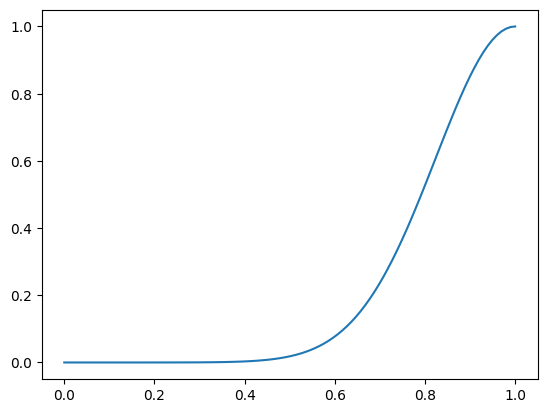

In [2]:
%matplotlib inline

x = np.linspace(0, 1, 100)

plt.plot(x, gprob(x, .25))

## Binary masks for distributions corresponding to each of 3 classes

Text(0.5, 0.98, 'Binary masks of 3 classes')

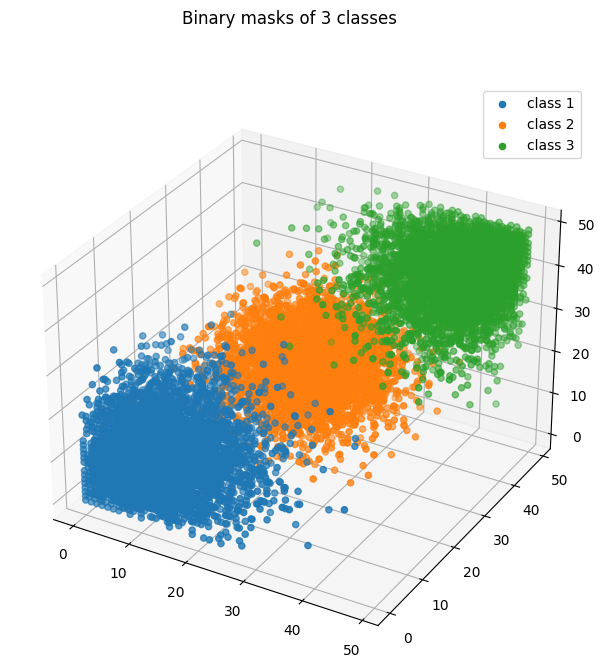

In [26]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5), subplot_kw=dict(projection='3d'))

shape = 50, 50, 50
sigma = .25

mask = gen_3d_prob((5, 5, 5), shape, partial(gprob, sigma=sigma))
ax.scatter(*np.where(mask == 1))
mask = gen_3d_prob((25, 25, 25), shape, partial(gprob, sigma=sigma/np.sqrt(2)))
ax.scatter(*np.where(mask == 1))
mask = gen_3d_prob((45, 45, 45), shape, partial(gprob, sigma=sigma))
ax.scatter(*np.where(mask == 1))
ax.legend(['class 1', 'class 2', 'class 3'])
fig.suptitle('Binary masks of 3 classes')

## 2D projections of voxels belonging to different classes

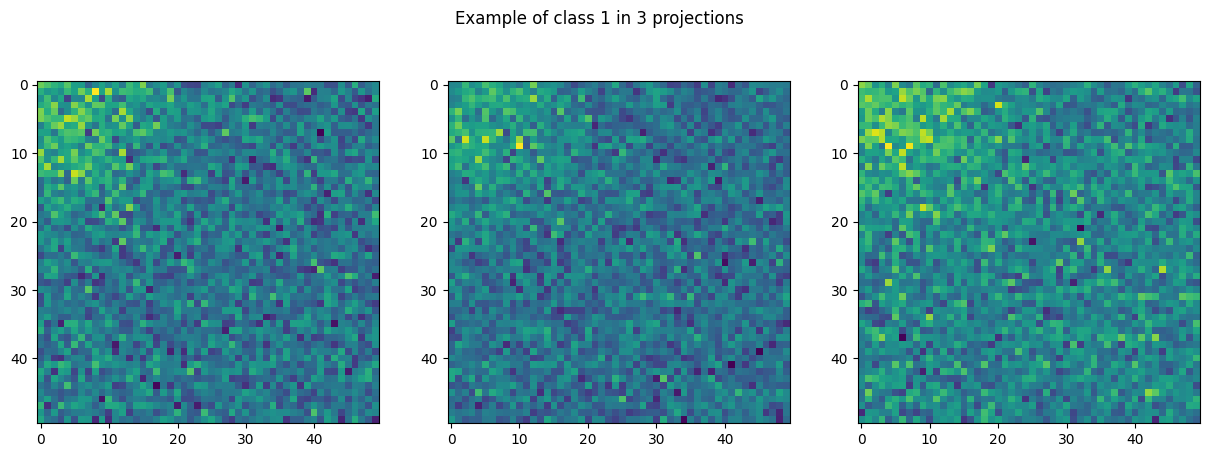

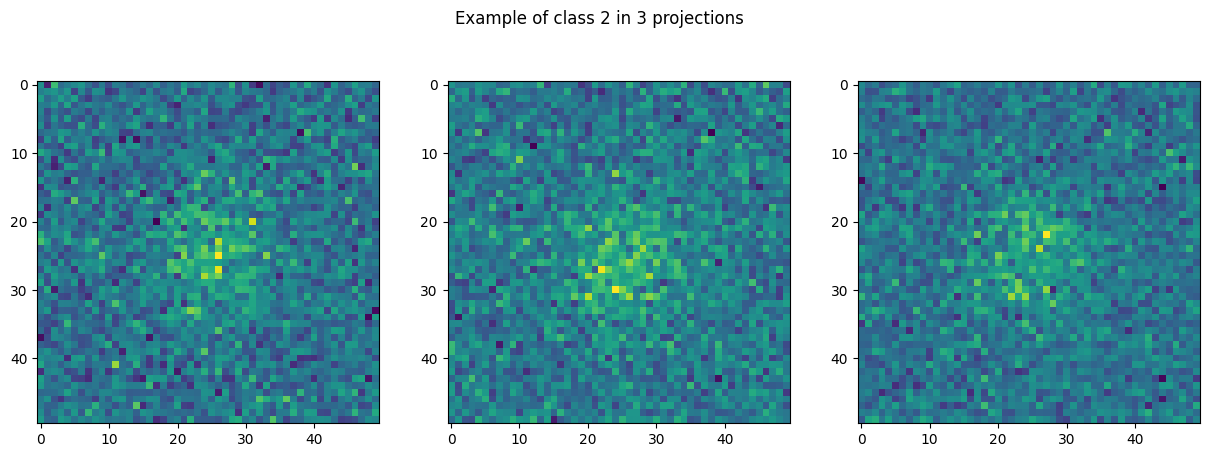

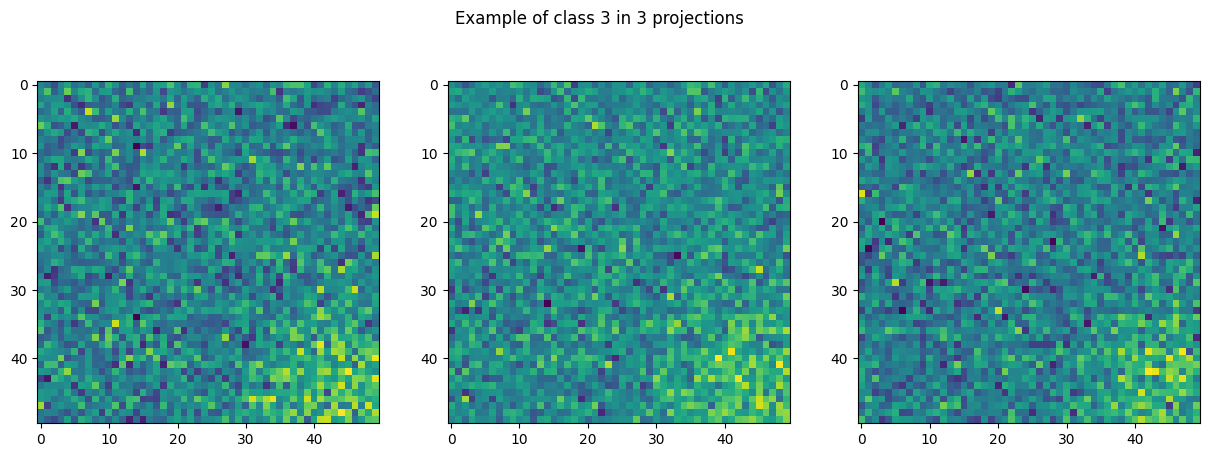

In [42]:
ratio = .5

mask = gen_3d_prob((5, 5, 5), shape, partial(gprob, sigma=sigma))
fig = plot_2d_projections(gen_3d_voxel(mask, ratio))
fig.suptitle('Example of class 1 in 3 projections')
plt.show()
mask = gen_3d_prob((25, 25, 25), shape, partial(gprob, sigma=sigma/np.sqrt(2)))
fig = plot_2d_projections(gen_3d_voxel(mask, ratio))
fig.suptitle('Example of class 2 in 3 projections')
plt.show()
mask = gen_3d_prob((45, 45, 45), shape, partial(gprob, sigma=sigma))
fig = plot_2d_projections(gen_3d_voxel(mask, ratio))
fig.suptitle('Example of class 3 in 3 projections')
plt.show()

## Generate data

In [53]:
clases = gen_3d_samples(
    shape,
    (5, 5, 5),
    100,
    partial(gprob, sigma=sigma),
    partial(gen_3d_voxel, ratio=ratio)
), gen_3d_samples(
    shape,
    (25, 25, 25),
    100,
    partial(gprob, sigma=sigma/np.sqrt(2)),
    partial(gen_3d_voxel, ratio=ratio)
), gen_3d_samples(
    shape,
    (45, 45, 45),
    100,
    partial(gprob, sigma=sigma),
    partial(gen_3d_voxel, ratio=ratio)
),

## Prepare dataset

In [54]:
X = np.concatenate(clases)
Y = one_hot_encoder(np.concatenate([np.full((len(class_)), i) for i, class_ in enumerate(clases)]))
dataset = EpochsDataset((X, Y), savepath='../datasets/voxels', transform = zscore)
dataset.save('../data/voxels.pt')
dataset = EpochsDataset.load('../data/voxels.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

## Example of a sample (2D projections)

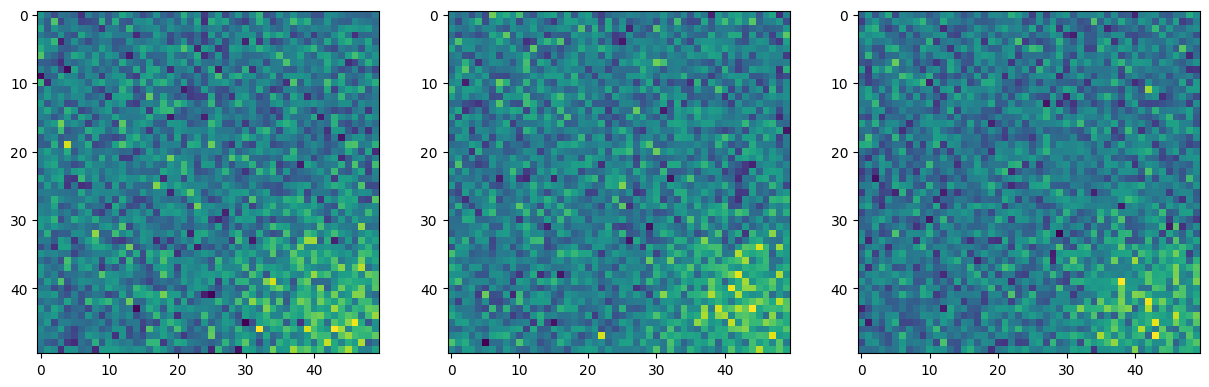

In [4]:
fig = plot_2d_projections(train[0][0])

## Initialize a model

In [6]:
model = VGG3D(
    shape=(50, 50, 50),
    n_conv_blocks=2,
    max_pool_size=(2, 2, 2),
    n_fc_layers=2,
    n_classes=3
)

optimizer = torch.optim.Adam

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=False)
    ]
)

## Train the model

Epoch 0:  loss_train:  0.6890   |    binary_accuracy_train:  0.5597   |    loss_val:  0.6990   |    binary_accuracy_val:  0.4722
Epoch 1:  loss_train:  0.5437   |    binary_accuracy_train:  0.9239   |    loss_val:  0.6879   |    binary_accuracy_val:  0.5833
Epoch 2:  loss_train:  0.4633   |    binary_accuracy_train:  0.9650   |    loss_val:  0.6819   |    binary_accuracy_val:  0.5903
Epoch 3:  loss_train:  0.4148   |    binary_accuracy_train:  0.9877   |    loss_val:  0.6826   |    binary_accuracy_val:  0.5972
Epoch 4:  loss_train:  0.3807   |    binary_accuracy_train:  0.9979   |    loss_val:  0.6789   |    binary_accuracy_val:  0.5764
Epoch 5:  loss_train:  0.3527   |    binary_accuracy_train:  0.9979   |    loss_val:  0.6691   |    binary_accuracy_val:  0.6181
Epoch 6:  loss_train:  0.3297   |    binary_accuracy_train:  1.0000   |    loss_val:  0.6613   |    binary_accuracy_val:  0.6111
Epoch 7:  loss_train:  0.3086   |    binary_accuracy_train:  1.0000   |    loss_val:  0.6570   | 

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

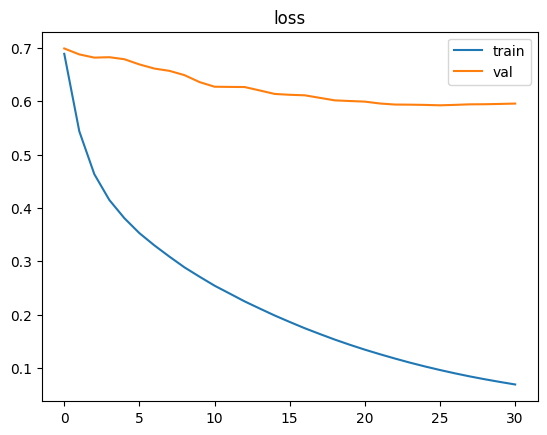

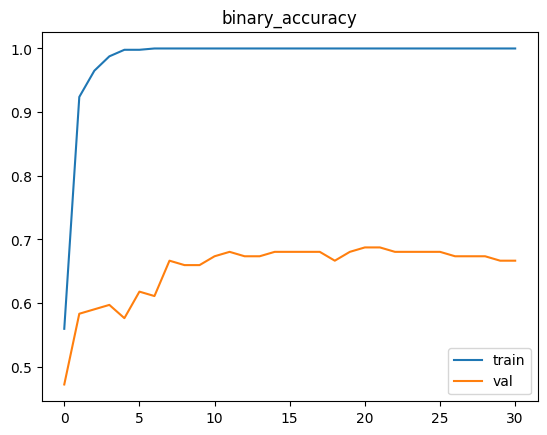

In [7]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60, update_every_n_batches=10)
plot_metrics(history)

In [8]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.20169559717178345
train_binary_accuracy: 0.9238095283508301
loss: 0.5912199020385742
binary_accuracy: 0.6592592597007751
